## 任务5   根据不同的标准对用户进行集群划分，如某一用户的行为特征、用户用电曲线形态   
## 保存为“电力用户集群分析模型.mdl”

## 1. 标准选取

本次将分别选取某一用户的行为特征和用户基本属性用电曲线形态对用户进行集群划分

## 2.  数据来源

本次模拟采用的是K-means聚类方法，数据源自[Pecan Street Energy Database](http://www.pecanstreet.org/)的数据库文件`dataport_sqlite`
数据包含了216户家庭的646981条用电量数据。

## 3. 采取用户用电曲线形态对用户进行集群划分

### 3.1 导入必要的模块

In [155]:
%matplotlib inline
 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3


### 3.2 从数据库文件中读取数据

In [156]:
# 从当前路径的数据库文件（dataport_sqlite）读取数据 
cwd = os.getcwd()
conn = sqlite3.connect(str(cwd) + "/dataport_sqlite") 
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

在pandas中导入数据

In [157]:
loads_df = pd.DataFrame(data, columns=['id','date','energy_use'])
loads_df
loads_df.to_csv('loads_df.csv',index=False)

数据中，id代表不同的用户；date代表时间，每15min采集一次；energy_use代表测量的电量，以kW表示。

In [158]:
#查看数据量
print("当前数据集含有%s行,%s列"%(loads_df.shape[0],loads_df.shape[1]))

当前数据集含有646981行,3列


In [159]:
#由采集数据的结果可知，记录的是15年7月一个月的用电情况
print(" 最早时间: %s \n 最晚时间: %s"%(loads_df.date.min(),loads_df.date.max()))

 最早时间: 2015-07-01 00:00:00 
 最晚时间: 2015-08-01 00:00:00


In [160]:
#查看id，可知不同的用户共有216户
loads_df['id'].value_counts()

26      2977
2859    2977
2667    2977
2710    2977
2742    2977
        ... 
3652    2604
297     1660
490     1447
2974    1188
1508     107
Name: id, Length: 220, dtype: int64

### 3.3 数据清洗

#### 3.3.1 删除空缺值

In [161]:
#查询数据中的空缺值
loads_df = loads_df.replace('',np.nan)
loads_df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

In [162]:
#删除空缺值
loads_df = loads_df.dropna()
loads_df.shape

(636286, 3)

删除后还有636286行数据

#### 3.3.2 改变数据类型

In [163]:
loads_df.time=loads_df.date.apply(lambda x:x.split( )[1])

In [16]:
time=loads_df.time.drop_duplicates().sort_values()

In [17]:
loads_df.loc[:,'energy_use'] = loads_df.energy_use.astype(float) 

loads_df.loc[:,'id'] = loads_df['id'].astype(int) 

loads_df.loc[:,'date'] = pd.to_datetime(loads_df.date) 

In [18]:
loads_df.head()

id                date  energy_use
0  26 2015-08-01 00:00:00    1.409067
1  26 2015-07-31 23:45:00    3.138733
2  26 2015-07-31 23:30:00    4.202133
3  26 2015-07-31 23:15:00    4.241800
4  26 2015-07-31 23:00:00    4.285733

### 3.4 特征工程

上述数据的时间仅为一列，无法较好的反映工作日与周末及每月具体日期的区别，因此尝试添加列进一步细化日期

In [19]:
# 添加一代表星期的列
loads_df.loc[:,'type_day'] = loads_df.date.apply(lambda x: x.isoweekday()) 

# 添加一代表日期的列
loads_df.loc[:,'day_of_month'] = loads_df.date.apply(lambda x: x.day) 

# 按照id和日期进行重新排序
loads_df = loads_df.sort_values(['id', 'date'], ascending=[True, True])
loads_df = loads_df.reset_index(drop=True)

In [20]:
loads_df.head()

id                date  energy_use  type_day  day_of_month
0  26 2015-07-01 00:00:00    1.571533         3             1
1  26 2015-07-01 00:15:00    0.871400         3             1
2  26 2015-07-01 00:30:00    1.571933         3             1
3  26 2015-07-01 00:45:00    3.406000         3             1
4  26 2015-07-01 01:00:00    3.417467         3             1

过滤掉周末，以便用户习惯更加一致，便于聚类

In [21]:
loads_df=loads_df[loads_df.type_day<=5]

改变数据结构

In [22]:
#按照日期和时间绘制数据透视表，获得不同时间下的用户用电数据
loads_wide_df = pd.pivot_table(data=loads_df,columns=['date','day_of_month'],values='energy_use',index=['id'])

In [23]:
loads_wide_df.head()

date         2015-07-01 00:00:00 2015-07-01 00:15:00 2015-07-01 00:30:00  \
day_of_month                  1                   1                   1    
id                                                                         
26                      1.571533            0.871400            1.571933   
59                      0.986667            0.947133            0.901800   
68                      0.318400            0.298733            0.250000   
77                      0.340333            0.442933            0.444133   
86                      0.208467            0.213467            0.211067   

date         2015-07-01 00:45:00 2015-07-01 01:00:00 2015-07-01 01:15:00  \
day_of_month                  1                   1                   1    
id                                                                         
26                      3.406000            3.417467            2.583333   
59                      0.896733            1.008133            0.841067   
68                      0.263667            0.325467            0.263267   
77                      0.389467            0.406067            0.434400   
86                      0.250800            0.320533            0.323133   

date         2015-07-01 01:30:00 2015-07-01 01:45:00 2015-07-01 02:00:00  \
day_of_month                  1                   1                   1    
id                                                                         
26                      0.837867            0.790133            0.834733   
59                      0.915400            0.851467            1.050067   
68                      0.250000            0.314333            0.318200   
77                      0.367333            0.391267            0.523733   
86                      0.310733            0.300333            0.291600   

date         2015-07-01 02:15:00  ... 2015-07-31 21:30:00 2015-07-31 21:45:00  \
day_of_month                  1   ...                  31                  31   
id                                ...                                           
26                      0.868467  ...            4.480667            4.474867   
59                      0.872133  ...            3.499867            2.251333   
68                      0.278733  ...            0.218200            0.237733   
77                      0.558467  ...            2.351200            2.667533   
86                      0.230667  ...            2.897400            3.641267   

date         2015-07-31 22:00:00 2015-07-31 22:15:00 2015-07-31 22:30:00  \
day_of_month                  31                  31                  31   
id                                                                         
26                      4.574867            4.448933            5.134600   
59                      3.897800            3.797467            2.279867   
68                      0.288533            0.286933            0.251200   
77                      3.279867            1.999000            2.049467   
86                      1.874733            1.219800            3.598200   

date         2015-07-31 22:45:00 2015-07-31 23:00:00 2015-07-31 23:15:00  \
day_of_month                  31                  31                  31   
id                                                                         
26                      4.505933            4.285733            4.241800   
59                      3.671600            1.521000            2.790000   
68                      0.219000            0.236600            0.296800   
77                      3.172933            1.993067            2.056200   
86                      1.756267            1.470400            3.479733   

date         2015-07-31 23:30:00 2015-07-31 23:45:00  
day_of_month                  31                  31  
id                                                    
26                      4.202133            3.138733  
59                      2.836133            1.430867  
68                      0.24360

In [24]:
#取10日当天数据进行分析
unique_days = loads_df.day_of_month.unique()
loads_wide_df = pd.concat([loads_wide_df.xs(10,level='day_of_month',axis=1) for day in unique_days])

In [25]:
loads_wide_df=loads_wide_df.drop_duplicates()

In [26]:
loads_wide_df.head()

date  2015-07-10 00:00:00  2015-07-10 00:15:00  2015-07-10 00:30:00  \
id                                                                    
26               3.694933             3.680733             3.647667   
59               0.401467             1.703000             0.395267   
68               0.131267             0.066000             0.066000   
77               0.606733             0.869933             1.350467   
86               0.332667             0.335200             0.266933   

date  2015-07-10 00:45:00  2015-07-10 01:00:00  2015-07-10 01:15:00  \
id                                                                    
26               2.960200             0.904000             0.971533   
59               1.623400             0.541400             0.453933   
68               0.108333             0.128667             0.066000   
77               1.526400             0.616000             1.605133   
86               0.237467             0.239800             0.240400   

date  2015-07-10 01:30:00  2015-07-10 01:45:00  2015-07-10 02:00:00  \
id                                                                    
26               1.012333             0.726533             0.447933   
59               1.602000             0.352067             1.479800   
68               0.068467             0.137200             0.134600   
77               0.857800             1.000400             1.499867   
86               0.358467             0.363000             0.344200   

date  2015-07-10 02:15:00  ...  2015-07-10 21:30:00  2015-07-10 21:45:00  \
id                         ...                                             
26               1.180933  ...             4.637733             4.588600   
59               0.608267  ...             2.463000             2.160467   
68               0.076933  ...             0.104800             0.065000   
77               0.850867  ...             1.499000             2.876733   
86               0.335533  ...             1.697933             0.849067   

date  2015-07-10 22:00:00  2015-07-10 22:15:00  2015-07-10 22:30:00  \
id                                                                    
26               4.446733             4.064600             4.134000   
59               1.007600             1.832400             1.966600   
68               0.065800             0.261467             0.256200   
77               2.173400             1.029733             1.634467   
86               2.865000             0.626867             5.820600   

date  2015-07-10 22:45:00  2015-07-10 23:00:00  2015-07-10 23:15:00  \
id                                                                    
26               1.800200             1.329867             1.324867   
59               0.608667             1.820000             0.531667   
68               0.383533             0.290333             0.327000   
77               2.302467             1.919933             0.778267   
86               7.699733             6.080067             3.346133   

date  2015-07-10 23:30:00  2015-07-10 23:45:00  
id                                              
26               3.689267             4.055200  
59               1.580400             0.966733  
68               0.370667             0.359467  
77               1.481867             1.614133  
86               2.249800             0.834000  

[5 rows x 96 columns]

查看缺失值，其中T代表将原有矩阵转置

In [27]:
#查看缺失值，其中T代表将原有矩阵转置
loads_wide_df.T.isnull().sum().sort_values(ascending=False).head()

id
1508    96
26       0
2907     0
2742     0
2751     0
dtype: int64

可见，用户1508缺失所有用电数据，可以将其删除

In [28]:
loads_wide_df = loads_wide_df.dropna(axis=0,how='any')

In [29]:
print('删除空值列后，当前数据集有%s行，%s列'%(loads_wide_df.shape[0],loads_wide_df.shape[1]))

删除空值列后，当前数据集有215行，96列


In [30]:
loads_wide_df.head()

date  2015-07-10 00:00:00  2015-07-10 00:15:00  2015-07-10 00:30:00  \
id                                                                    
26               3.694933             3.680733             3.647667   
59               0.401467             1.703000             0.395267   
68               0.131267             0.066000             0.066000   
77               0.606733             0.869933             1.350467   
86               0.332667             0.335200             0.266933   

date  2015-07-10 00:45:00  2015-07-10 01:00:00  2015-07-10 01:15:00  \
id                                                                    
26               2.960200             0.904000             0.971533   
59               1.623400             0.541400             0.453933   
68               0.108333             0.128667             0.066000   
77               1.526400             0.616000             1.605133   
86               0.237467             0.239800             0.240400   

date  2015-07-10 01:30:00  2015-07-10 01:45:00  2015-07-10 02:00:00  \
id                                                                    
26               1.012333             0.726533             0.447933   
59               1.602000             0.352067             1.479800   
68               0.068467             0.137200             0.134600   
77               0.857800             1.000400             1.499867   
86               0.358467             0.363000             0.344200   

date  2015-07-10 02:15:00  ...  2015-07-10 21:30:00  2015-07-10 21:45:00  \
id                         ...                                             
26               1.180933  ...             4.637733             4.588600   
59               0.608267  ...             2.463000             2.160467   
68               0.076933  ...             0.104800             0.065000   
77               0.850867  ...             1.499000             2.876733   
86               0.335533  ...             1.697933             0.849067   

date  2015-07-10 22:00:00  2015-07-10 22:15:00  2015-07-10 22:30:00  \
id                                                                    
26               4.446733             4.064600             4.134000   
59               1.007600             1.832400             1.966600   
68               0.065800             0.261467             0.256200   
77               2.173400             1.029733             1.634467   
86               2.865000             0.626867             5.820600   

date  2015-07-10 22:45:00  2015-07-10 23:00:00  2015-07-10 23:15:00  \
id                                                                    
26               1.800200             1.329867             1.324867   
59               0.608667             1.820000             0.531667   
68               0.383533             0.290333             0.327000   
77               2.302467             1.919933             0.778267   
86               7.699733             6.080067             3.346133   

date  2015-07-10 23:30:00  2015-07-10 23:45:00  
id                                              
26               3.689267             4.055200  
59               1.580400             0.966733  
68               0.370667             0.359467  
77               1.481867             1.614133  
86               2.249800             0.834000  

[5 rows x 96 columns]

依据当前结果，绘制当日不同时间不同用户的用电特征曲线

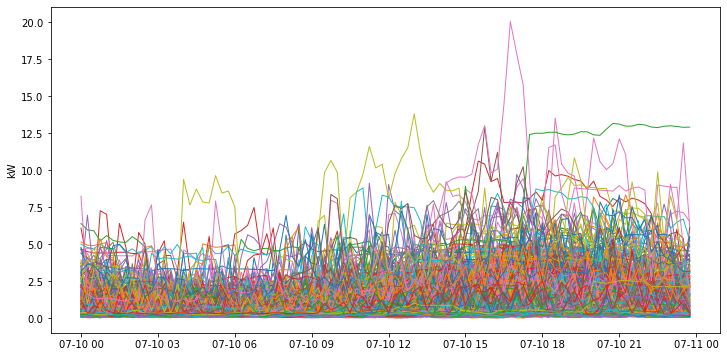

In [32]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(loads_wide_df.T,alpha=1,lw=1)
plt.ylabel('kW')
plt.show()

可以看到当前数据比较杂乱，完全看不出规律，下面我们将当前获得的数据进行聚类

### 3.5 聚类模型

In [87]:
#导入聚类模块
from sklearn.cluster import KMeans 
import warnings
warnings.filterwarnings("ignore")

In [88]:
#构建模型，同时为了便于后期可视化分析，这里我们建立一个绘制图像的类
class EnergyFingerPrints():
     
    def __init__(self,data):   
        self.means = [] 
        self.data = data

    def elbow_method(self,n_clusters):
    # 拐点计算，计算不同聚类簇数量下各簇内样本点到中心点距离之和，对比选择最合适的聚类簇数n_clusters
        fig,ax=plt.subplots(figsize=(8,4)) 
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++', #初始中心簇的获取方式，k-means++一种比较快的收敛的方法
                        n_init=10,        #初始中心簇的迭代次数
                        max_iter=300,     #数据分类的迭代次数
                        random_state=0)   #初始化中心簇的方式
            km.fit(self.data)
            distortions.append(km.inertia_) #inertia计算样本点到最近的中心点的距离之和
        
        plt.plot(range(1,n_clusters), distortions, marker='o',lw=1) #绘制聚类数量与距离的关系曲线
        plt.xlabel('聚类数量')
        plt.ylabel('至中心点距离之和')
        
    def get_cluster_counts(self):       #返回各簇中用户的数量
        return pd.Series(self.predictions).value_counts()
    
    def labels(self,n_clusters):        #返回各簇中用户的id
        self.n_clusters = n_clusters
        return KMeans(self.n_clusters, init='k-means++', n_init=10,max_iter=300,random_state=0).fit(self.data).labels_
        
    def fit(self,n_clusters):          #按照指定的聚类簇数量对给定数据进行聚类分析
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

    def plot(self):                    #按照聚类结果，绘制各类中的用户用电曲线和其平均用电行为曲线
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        fig,ax=plt.subplots(figsize=(12,16))

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.06,color="blue",lw=2)
                        #plt.ylim(0,4)
                        plt.xlim(0,96)
                        plt.title('Cluster%s'%(i+1))
                        plt.ylabel('用电量/kW')
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
    def plot_energy_fingerprints(self):          #将各簇的用户平均用电行为曲线绘制在一张表中
        fig,ax=plt.subplots(figsize=(8,5))
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster %s"%(str(i+1)))
            plt.xlim(0,96)
        plt.ylabel('用户用电量/kW')
        plt.xlabel('用户用电时刻')
        plt.xticks([0,20,40,60,80],['00:00','05:00','10:00','15:00','20:00'],rotation=60)  #将横坐标的数字用时间点来进行替换，并旋转60°
        plt.legend()

In [89]:
#将loads_wide_df数据转换成多维数组
load_data=np.array(loads_wide_df)

In [90]:
#将数据导入类并生成计算模型
energy_clusters = EnergyFingerPrints(load_data)

计算聚类簇的距离

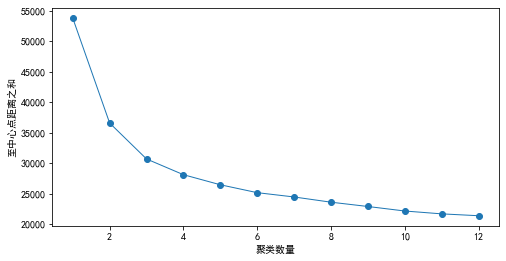

In [91]:
#分析不同聚类数量下，各簇中的样本点距离中心点距离之和
energy_clusters.elbow_method(n_clusters=13)

显然，随着聚类簇数n的增加，样本点至中心簇间的距离逐渐减小。
并且，在聚类簇数量为4时，距离呈现出一较为明显的拐点，因此，这里我们去聚类簇的数量为4组。

### 3.6 数据挖掘系统测试分析

In [92]:
#构建一个聚类簇为4的模型
energy_clusters.fit(n_clusters = 4)

模型结果分组

In [93]:
#查看各簇中的用户数量，可以看到0,1,2,3组的用户数量
energy_clusters.get_cluster_counts()

3    87
2    85
0    35
1     8
dtype: int64

In [94]:
#获得各用户所属于的簇标签
group=energy_clusters.labels(n_clusters = 4) 

#获得用户的id
num=loads_wide_df.index

#将用户id和用户的分类簇整合起来，形成一个新的表cls
cls=pd.DataFrame(list(num))
cls['cluster']=list(group)
cls.columns=['user_id','cluster']

#将获得的数据按照簇类别（cluster）进行划分，并重置索引。可以得到每个簇中的用户id
cls=cls.sort_values(by='cluster',ascending=True) 
cls.reset_index(drop=True)

user_id  cluster
0       2034        0
1       2769        0
2       2751        0
3       2667        0
4       2606        0
..       ...      ...
210      604        3
211     1507        3
212     3126        3
213     1202        3
214     2018        3

[215 rows x 2 columns]

In [95]:
#筛选可获得属于第一分类簇的用户id
np.array(cls.loc[cls.cluster ==0].user_id)

array([2034, 2769, 2751, 2667, 2606, 2401, 2378, 2337, 2207, 2199, 2075,
       4031, 1879, 1832, 1766, 1731, 1586, 1577, 1524, 1500, 1450, 1415,
       1350, 1334, 1310, 1192, 2829, 2859, 2907, 2945, 4022, 3938, 3935,
       3886, 3873, 3864, 3831, 3829, 3778, 3687, 3678, 3631, 1169, 3538,
       3482, 3443, 3413, 3368, 3299, 3268, 3224, 3104, 3036, 2992, 2965,
       2953, 3531, 1103, 4042,  624,  267,  410,  645,  436,  203,  575,
        457,  171,  470,  160,  130,  297,  573,  547,  772,  739,  507,
        115,  491,   94,  871,   68,  516,  954,  936], dtype=int64)

In [96]:
#筛选可获得属于第二分类簇的用户id
np.array(cls.loc[cls.cluster ==1].user_id)

array([ 364, 3039, 2641, 3009,  499, 2986, 2818, 2814, 2931, 2742, 2864,
        484, 2755, 2787, 2980, 3134, 2710,  275,   59, 3967,   77, 3893,
         86,   93, 3849,  101,  114, 3736, 3723, 3721, 3719,  121, 3649,
       3577, 3527, 3510, 3506, 3456,  232, 3392, 2638, 3310, 3273, 3192,
       2575,   26, 2532, 1953, 1403, 1947,  781, 1463,  585,  744,  668,
       1830,  661, 1800, 1792, 1617, 2557, 1629, 1632, 1714, 1642, 1700,
       1681,  580, 2004,  946,  994, 1086, 2470, 2461, 2449, 2365, 2361,
       1392, 1696, 2158, 2072,  821, 2171,  861, 1314, 2156,  890],
      dtype=int64)

In [97]:
#筛选可获得属于第三分类簇的用户id
np.array(cls.loc[cls.cluster ==2].user_id)

array([ 187, 3918, 3635, 1589, 3953, 3652, 1185, 1283, 3795,  252, 1697,
        503, 2472,  545,  490, 2335, 2242, 2233,  483, 2925, 2129, 2094,
        434, 3500,  370,  974, 3092,  222, 3221, 1801, 1718, 1791, 3044,
       1790, 3367], dtype=int64)

In [98]:
#筛选可获得属于第四分类簇的用户id
np.array(cls.loc[cls.cluster ==3].user_id)

array([3401, 3394, 3916,  604, 1507, 3126, 1202, 2018], dtype=int64)

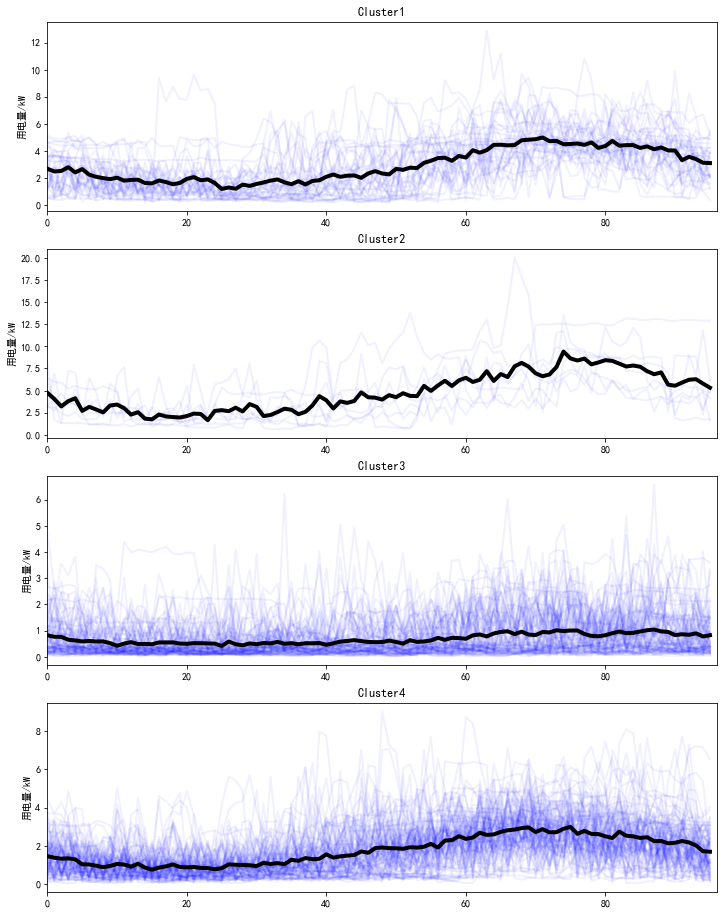

In [99]:
#各个分类簇的用户数据进行对比，其中蓝线代表不同用户的曲线，黑色的线为所有用户用电量的平均曲线
plt.rcParams['font.sans-serif'] = ['simhei']
energy_clusters.plot()

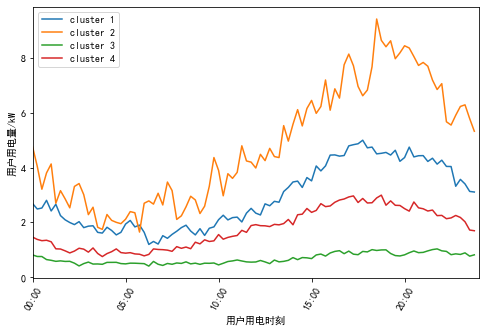

In [100]:
#将各簇用户用电行为曲线绘制在同一图表中
energy_clusters.plot_energy_fingerprints()

## 4 采取用户行为特征对用户进行集群划分

### 4.1 导入必要的模块

In [104]:
import pandas as pd
import sklearn.preprocessing
import sklearn.cluster
from sklearn.cluster import KMeans

### 4.2 数据预处理

读取以用电曲线形态集群划分后的数据loads_df.csv

In [107]:
data=pd.read_csv(r"C:\Users\15317\jupyter\new power\loads_df.csv")
data

id       date      time  energy_use
0         26  2015/7/31  23:45:00    3.138733
1         26  2015/7/31  23:30:00    4.202133
2         26  2015/7/31  23:15:00    4.241800
3         26  2015/7/31  23:00:00    4.285733
4         26  2015/7/31  22:45:00    4.505933
...      ...        ...       ...         ...
636070  4042   2015/7/1   0:45:00    1.208600
636071  4042   2015/7/1   0:30:00    0.498800
636072  4042   2015/7/1   0:15:00    0.033000
636073  4042   2015/7/1   0:00:00    0.037133
636074  6000   2015/8/1   0:00:00    0.037133

[636075 rows x 4 columns]

将其按照月份分为多个xls文件

In [ ]:
id=26
sum=0
da="2015/7/31"
sx=[]#all
fr=[]#id time euse
hr=23
for i in range(636075):
# for i in range((100)):
    hour=data.iloc[i,2].split(':')
    if data.iloc[i,0]!=6000:
        if data.iloc[i,0]==id:
            if data.iloc[i,1]==da:
                if hr==int(hour[0]):
                    sum+=data.iloc[i,3]
                else:
                    hr=int(hour[0])
                    hour=data.iloc[i-1,2].split(':')
#                     print(hour)
                    fr=[]
                    fr=[data.iloc[i,0]]
                    fr.append(f"{int(hour[0])+1}:00-{int(hour[0])}:00")
                    fr.append(sum)
                    sum=0
                    sx.append(fr)
                    sum+=data.iloc[i,3]
#                     print(fr)
            else:
                hr=int(hour[0])
                hour=data.iloc[i-1,2].split(':')
                fr=[]
                fr.append(data.iloc[i,0])
                fr.append(f"{int(hour[0])+1}:00-{int(hour[0])}:00")
                fr.append(sum)
                sum=0
                sx.append(fr)
                sum+=data.iloc[i,3]
                names = ["user","小时","电量（kWh）"]
                test = pd.DataFrame(columns = names,data=sx)
#                 print(test)
                dad=da.split("/")
                test.to_excel(f'E:\\different\\{data.iloc[i-1,0]} {dad[0]}年{dad[1]}月{dad[2]}日.xls',index=False,encoding='utf_8_sig')
                da=data.iloc[i,1]
                sx=[]
        else:
            hr=int(hour[0])
            hour=data.iloc[i-1,2].split(':')
            fr=[]
            fr.append(data.iloc[i-1,0])
            fr.append(f"{int(hour[0])+1}:00-{int(hour[0])}:00")
            fr.append(sum)
            sum=0
            sx.append(fr)
            sum+=data.iloc[i,3]
            names = ["user","小时","电量（kWh）"]
            test = pd.DataFrame(columns = names,data=sx)
            dad=da.split("/")
            dirName=f"用户{data.iloc[i,0]}"
            test.to_excel(f'E:\\different\\{data.iloc[i-1,0]} {dad[0]}年{dad[1]}月{dad[2]}日.xls',index=False,encoding='utf_8_sig')
            id=data.iloc[i,0]
            sx=[]
    else:
        hr=int(hour[0])
        hour=data.iloc[i-1,2].split(':')
        fr=[]
        fr.append(data.iloc[i-1,0])
        fr.append(f"{int(hour[0])+1}:00-{int(hour[0])}:00")
        fr.append(sum)
        sx.append(fr)
        names = ["user","小时","电量（kWh）"]
        test = pd.DataFrame(columns = names,data=sx)
        dad=da.split("/")
        test.to_excel(f'E:\\different\\{data.iloc[i-1,0]} {dad[0]}年{dad[1]}月{dad[2]}日.xls',index=False,encoding='utf_8_sig')
        sx=[]
# data.iloc[0,2].split(':')
# hour=data.iloc[1,2].split(':')
# int(hour[0])

后将数据按照用户id进行划分

In [ ]:
import os
import shutil

# 想要移动文件所在的根目录
rootdir = r"E:\\different"
# 获取目录下文件名清单
list = os.listdir(rootdir)
for i in range(0, len(list)):  # 遍历目录下的所有文件夹
    path = os.path.join(rootdir, list[i])
    list_split1=list[i].split('.')
    list_split2=list_split1[0].split(' ')
#     print(list_split2)
    for h in range(26,4043):
        if int(list_split2[0])==h:
            des_path = f"E:\\{h}"
            shutil.move(path,des_path)
            break

结果如下：
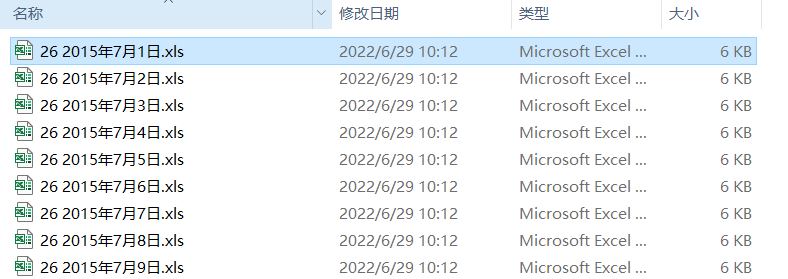

In [ ]:
path = './芙蓉兴国/mewtown'
files = list(os.listdir(path))  # 读入文件夹
# print(files)
for j in range(len(files)):
    result = []
    # print('./芙蓉兴国/mewtown'+files[j])
    s='./芙蓉兴国/mewtown/'+files[j]
    file=list(os.listdir(s))
    print(files[j])
    for k in file:
        data=pd.read_excel(s+'/'+k)
        data=data.loc[:23,['小时','电量（kWh）']]
        data=np.array(data)
        # print(data)

        # 对于整个数据倒序
        data=data[::-1]
        # print(data)

        # 对时间段重新编号
        for i in range(len(data)):
            data[i][0]=i+1
        # print(data)

        # 标准化电量
        elec=data[:,1].reshape(-1,1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(elec)
        elec= scaler.transform(elec).reshape(1,-1)[0]
        # print(elec)

        # 后项-前项
        e=[]
        for i in range(len(elec)):
            if i!=23:
                e.append(elec[i+1]-elec[i])
            else:
                e.append(-2)
        e=np.array(e)
        # print(e)

        # 日期
        p1 = r"\d{4}\D\d{1,2}\D\d{1,3}\D{1}"
        pattern1 = re.compile(p1)
        finish_date = pattern1.findall(k)
        # print(finish_date)
        results=[finish_date[0]]

        # 上升剧烈的前三个点
        d1=(np.argsort(e)[-3:]+1)[::-1].tolist()
        results.append(d1)

        # 集中用电的五个点
        d2=(np.argsort(elec)[-5:]+1)[::-1].tolist()
        results.append(d2)

        # 下降剧烈的点
        d3=(np.argsort(e)[1:4]+1)[::-1].tolist()
        results.append(d3)

        # 计算标准差
        std=np.std(elec)
        results.append(std)

        # 计算均值
        mea=np.mean(data[:,1].reshape(-1,1))
        results.append(mea)

        result.append(results)

    names = ['日期','上升剧烈的点','集中用电的点','下降剧烈的点','标准差','均值']
    result=pd.DataFrame(data=result,columns=names)
    result.to_csv('芙蓉兴国'+files[j]+'.csv', index=False, encoding='utf-8-sig')

结果如下：
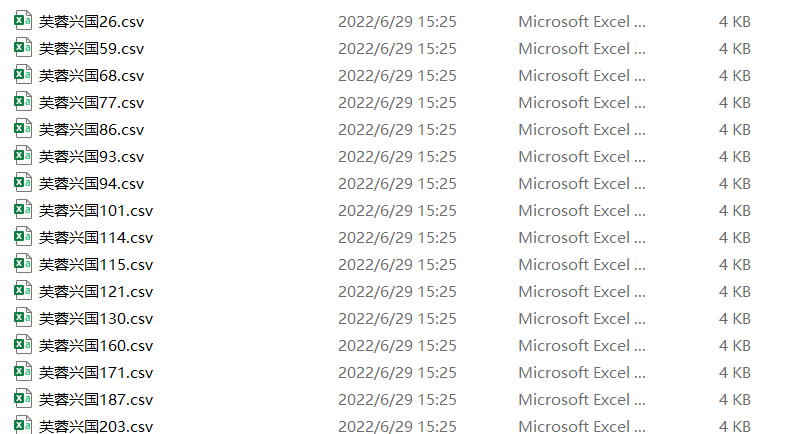

### 4.3 数据转换与特征工程

针对原有的数据提出了两种特征选取标准：
1. 成长度(用电客户的月用电量的增长率)计算式：用电月增长率=(本月电量一上月用电量)/上月用电量
2. 贡献度(主要从电量指标来衡量)计算式:日平均用电=累计日用电量/一日的用电时间

将不同用户计算其特征(成长度和贡献度)并统计到一张表中进行分析

In [125]:
data=pd.read_csv(r'C:\Users\15317\jupyter\new power\loads_df.csv')
genres = np.unique(data['id'])
data.head()

id       date      time  energy_use
0  26  2015/7/31  23:45:00    3.138733
1  26  2015/7/31  23:30:00    4.202133
2  26  2015/7/31  23:15:00    4.241800
3  26  2015/7/31  23:00:00    4.285733
4  26  2015/7/31  22:45:00    4.505933

In [128]:
genres = np.unique(data['id'])
time=[]
mon=[]
for i in range(1,32):
    time.append(f"2015年7月{i}日")
    mon.append(0)
print(time)
print(genres)

['2015年7月1日', '2015年7月2日', '2015年7月3日', '2015年7月4日', '2015年7月5日', '2015年7月6日', '2015年7月7日', '2015年7月8日', '2015年7月9日', '2015年7月10日', '2015年7月11日', '2015年7月12日', '2015年7月13日', '2015年7月14日', '2015年7月15日', '2015年7月16日', '2015年7月17日', '2015年7月18日', '2015年7月19日', '2015年7月20日', '2015年7月21日', '2015年7月22日', '2015年7月23日', '2015年7月24日', '2015年7月25日', '2015年7月26日', '2015年7月27日', '2015年7月28日', '2015年7月29日', '2015年7月30日', '2015年7月31日']
[  26   59   68   77   86   93   94  101  114  115  121  130  160  171
  187  203  222  232  252  267  275  297  364  370  410  434  436  457
  470  483  484  490  491  499  503  507  516  545  547  573  575  580
  585  604  624  645  661  668  739  744  772  781  821  861  871  890
  936  946  954  974  994 1086 1103 1169 1185 1192 1202 1283 1310 1314
 1334 1350 1392 1403 1415 1450 1463 1500 1507 1508 1524 1577 1586 1589
 1617 1629 1632 1642 1681 1696 1697 1700 1714 1718 1731 1766 1790 1791
 1792 1800 1801 1830 1832 1879 1947 1953 2004 2018 2034 2072 2075 2094
 2129 

In [139]:
newson=[]
idd=genres[0]
for i in genres:
    try:
        path=pd.read_csv(f"E:\\downloads\\中国电力统计年鉴2020\\芙蓉兴国\\芙蓉兴国{i}.csv")
        son=[]
        son.append(i)
        for h in range(31):
            a=time.index(path.iloc[h,0])
            mon[a]=path.iloc[h,5]
        sa=sum(mon)/len(mon)
        son.append(sa)
        st=[]
        for i in range(len(mon)):
            if i==0:
                continue
            else:
                st.append((mon[i]-mon[i-1])/mon[i-1])
        son.append(sum(st)/len(st))
        newson.append(son)
    except:
        continue
newson

[[26, 9.204495609305107, 0.029684981679529564],
 [59, 7.635832078849462, 0.13077900491352085],
 [68, 1.225134408577957, 0.044646404660925725],
 [77, 8.084740949805107, 0.05130223090885011],
 [86, 9.309795878126344, 0.036375973253653965],
 [93, 7.729869802848119, 0.030788551844393313],
 [94, 2.7830813620161288, 0.040338039071420174],
 [101, 4.7570841397943555, 0.038493946957904285],
 [114, 8.132204749106183, 0.04095348885535659],
 [115, 2.8191638888749995, 0.02418532512331884],
 [121, 8.503303225807795, 0.020584031324408874],
 [130, 3.1160046595040316, -0.003129314522461749],
 [160, 3.734468727606183, 0.04604154390840381],
 [171, 4.921426702543011, 0.053511388508496835],
 [187, 10.197164157709677, 0.017075876014944022],
 [203, 2.389371057329301, 0.036148675519750276],
 [222, 18.759886111087365, 0.05982008593534211],
 [232, 6.57445663078629, 0.06290402647534779],
 [252, 14.15384462364516, 0.013212885570630727],
 [267, 2.421730734736559, 0.0964704874485916],
 [275, 5.642677598564515, 0.03

In [140]:
names = ["user","avg","growth"]
test = pd.DataFrame(columns = names,data=newson)
test.to_csv('E:\\kmeans用户电力表.csv',index=False,encoding='utf_8_sig')

In [130]:
a = pd.read_csv(r'E:\kmeans用户电力表.csv')
a.head()

user       avg    growth
0    26  9.204496  0.029685
1    59  7.635832  0.130779
2    68  1.225134  0.044646
3    77  8.084741  0.051302
4    86  9.309796  0.036376

### 4.4 聚类及数据挖掘系统测试分析

In [131]:
a = pd.read_csv(r'E:\kmeans用户电力表.csv')
features=['avg', 'growth']
data = a[features]
features =['avg', 'grow']
data.columns = features
print(data.describe().T)

ss = sklearn.preprocessing.StandardScaler(with_mean=True, with_std=True)#标准化
data = ss.fit_transform(data) #数据转换
data = pd.DataFrame(data, columns=features)
print(data.describe().T)

      count      mean       std       min       25%       50%       75%  \
avg   210.0  7.071279  4.239000  0.916358  3.756966  6.622047  9.291731   
grow  210.0  0.051441  0.063021 -0.008080  0.022765  0.036227  0.054567   

            max  
avg   22.795682  
grow   0.679363  
      count          mean       std       min       25%       50%       75%  \
avg   210.0 -2.379049e-16  1.002389 -1.455444 -0.783730 -0.106229  0.525067   
grow  210.0 -2.854859e-17  1.002389 -0.946732 -0.456113 -0.242000  0.049717   

           max  
avg   3.718324  
grow  9.987538  


In [132]:
a = pd.read_csv(r'E:\kmeans用户电力表.csv')
a = pd.DataFrame(a, columns=['avg', 'growth'])
a

avg    growth
0     9.204496  0.029685
1     7.635832  0.130779
2     1.225134  0.044646
3     8.084741  0.051302
4     9.309796  0.036376
..         ...       ...
205  13.460275  0.050534
206   9.418299  0.050906
207   2.666991  0.034254
208   6.674751  0.028790
209   2.534412  0.115211

[210 rows x 2 columns]

In [133]:
k = 4
## 确定聚类中心数
#构建模型
kmeans_model = KMeans(n_clusters = k,random_state=123)
fit_kmeans = kmeans_model.fit(a) #模型训练
kmeans_model.cluster_centers_ #查看聚类中心
print(kmeans_model.cluster_centers_)
kmeans_model.labels_ #查看样本的类别标签

print(kmeans_model.labels_)
#统计不同类别样本的数目
r1 = pd.Series(kmeans_model.labels_).value_counts()
print('最终每个类别的数目为：\n', r1)

[[ 2.9073972   0.07431085]
 [11.20138319  0.02836034]
 [19.58439177  0.0281014 ]
 [ 6.75228023  0.04871269]]
[1 3 0 3 1 3 0 0 3 0 3 0 0 3 1 0 2 3 1 0 3 3 3 1 0 0 0 3 0 3 1 0 0 1 0 0 0
 3 3 2 0 0 1 3 0 3 0 3 0 3 3 3 0 3 0 2 3 3 3 3 1 3 1 1 0 3 3 0 3 0 3 3 3 0
 2 0 0 0 1 3 3 3 1 3 1 1 3 1 1 0 0 1 1 3 3 1 1 0 0 3 3 3 2 3 1 0 1 1 3 1 1
 0 0 1 1 1 0 3 0 3 0 3 3 3 1 3 3 3 0 1 3 0 1 3 0 3 3 1 3 3 3 0 3 3 1 3 0 0
 3 3 3 0 3 3 1 1 1 0 2 3 3 1 3 0 0 0 3 1 0 3 2 2 3 0 0 3 1 3 0 3 0 3 3 0 1
 1 3 0 1 3 3 3 3 1 3 0 3 0 0 0 3 2 1 0 0 1 1 0 3 0]
最终每个类别的数目为：
 3    87
0    67
1    47
2     9
dtype: int64


In [135]:
a['sort']=kmeans_model.labels_

In [136]:
a.head()

avg    growth  sort
0  9.204496  0.029685     1
1  7.635832  0.130779     3
2  1.225134  0.044646     0
3  8.084741  0.051302     3
4  9.309796  0.036376     1

In [137]:
names=['sort','avg','growth']
test = pd.DataFrame(columns = names,data=a)
test.to_csv('E:\\kmeans数据集聚类标注.csv',index=False,encoding='utf_8_sig')

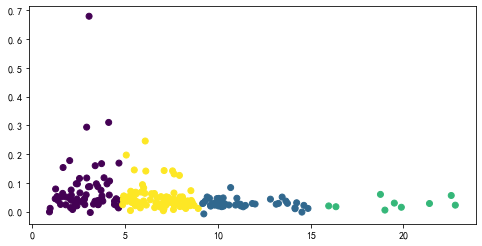

In [138]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv(r'E:\\kmeans数据集聚类标注.csv')
plt.figure(figsize=(8,4))
plt.scatter(data.iloc[:,1],data.iloc[:,2],c=data.iloc[:,0])

plt.savefig(r'E:\\1.png',dpi=300,pad_inches=0)
plt.show()

经查询,去掉点growth成长度超过0.6的用户id为1586的点

重新聚一次类

In [142]:
a = pd.read_csv(r'E:\kmeans用户电力表.csv')
a = pd.DataFrame(a, columns=['avg', 'growth'])

In [143]:
k = 4
## 确定聚类中心数
#构建模型
kmeans_model = KMeans(n_clusters = k,random_state=123)
fit_kmeans = kmeans_model.fit(a) #模型训练
kmeans_model.cluster_centers_ #查看聚类中心
print(kmeans_model.cluster_centers_)
kmeans_model.labels_ #查看样本的类别标签

print(kmeans_model.labels_)
#统计不同类别样本的数目
r1 = pd.Series(kmeans_model.labels_).value_counts()
print('最终每个类别的数目为：\n', r1)

[[ 2.90523236  0.06514339]
 [11.20138319  0.02836034]
 [ 6.75228023  0.04871269]
 [19.58439177  0.0281014 ]]
[0 0 2 2 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 1 2 0 0 0 2 2 2 2 0
 2 2 0 2 2 2 2 2 3 0 2 0 0 3 0 2 2 0 2 2 0 2 2 2 2 1 2 1 0 2 1 2 1 1 0 1 0
 1 0 0 2 0 0 1 1 2 2 2 2 2 2 2 0 2 2 0 2 0 0 0 2 2 1 1 0 0 0 0 0 2 0 0 2 2
 2 2 2 1 2 2 2 1 2 1 1 3 1 2 2 2 1 1 1 0 3 1 2 1 2 1 2 1 0 1 1 1 2 2 0 0 2
 0 0 0 2 1 0 1 1 1 2 2 1 3 1 1 2 2 2 2 1 2 2 2 0 1 2 3 1 1 1 1 0 0 2 2 1 3
 1 0 2 3 2 0 1 2 0 0 1 2 2 1 2 0 2 3 2 2 0 1 0 1]
最终每个类别的数目为：
 2    87
0    66
1    47
3     9
dtype: int64


In [144]:
a['sort']=kmeans_model.labels_
names=['sort','avg','growth']
test = pd.DataFrame(columns = names,data=a)
test.to_csv('E:\\kmeans数据集聚类标注.csv',index=False,encoding='utf_8_sig')

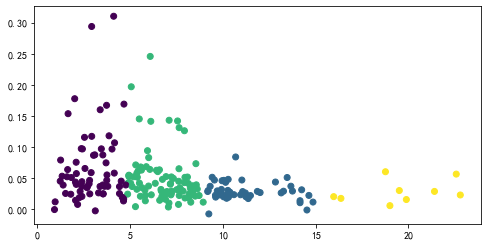

In [145]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv(r'E:\\kmeans数据集聚类标注.csv')
plt.figure(figsize=(8,4))
plt.scatter(data.iloc[:,1],data.iloc[:,2],c=data.iloc[:,0])

plt.savefig(r'E:\\1.png',dpi=300,pad_inches=0)
plt.show()

绘制饼状图将其结果输出为kmeans用户价值分层.html

第3类映射为用户A类，第1类映射为用户B类，第2类映射为用户C类,第0类映射为用户D类

In [151]:
#然后手动去掉
#用户价值分层玫瑰图
from pyecharts import options as opts
from pyecharts.charts import Pie
import pandas as pd
import matplotlib.pyplot as plt
from pyecharts.faker import Faker
plt.rcParams['font.sans-serif'] = ['simhei']
# x = ['重要保持客户','重要发展客户','重要挽留客户','一般客户','低价值客户']
x=['用户A类', '用户B类', '用户C类', '用户D类']
y = [9,47,87,66]
c = (
    Pie().add("",list(zip(x, y)),radius=["40%", "75%"],).set_global_opts(title_opts=opts.TitleOpts(title="用户价值分层"),legend_opts=opts.LegendOpts(orient="vertical", pos_top="15%",pos_left="2%"),).set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}")).render("kmeans用户价值分层.html"))

结果为:
    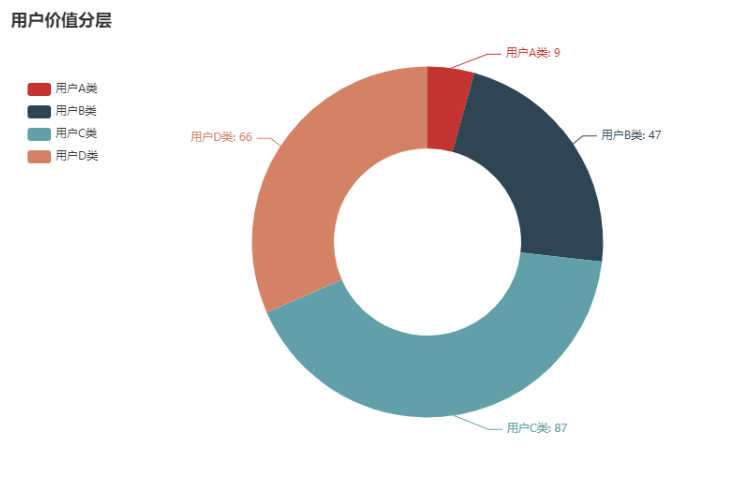

## 5. 结论

显然，依据上述聚类结果，由上至下4类用户的用电行为存在明显差异：    
第一类用户：用电量始终维持在一较高位置，峰值用电量达到了9kWh，即使在最低的时段也有2kWh的用电量，因此这部分用户有可能是部分小生产商或者手工业者。针对这部分用电需求显著的用户，可以提供更合理的用电服务，以便满足其用电需求；    
第二类用户：用电量较之第一类用户显著降低，在夜晚用电量出现明显升高，峰值用电量达到了5kWh，推断应该是普通家庭用电；  
第三类用户：用电曲线类似于第二类用户，但其用电量却明显小于第二类用户。是家庭用电的可能性较大，然而和第二类用户存在明显的用电量差异，可能是由于家庭状况导致的家电用电量消耗不同所致；  
第四类用户：可以看出，这类用户用电量恒处在一个较低的位置，用电量近似维持在1kW，有可能是由于仅有照明灯普通需求的场所，或者是已装修的闲置二手房。  
  
本次分析，是在获取用电行曲线上的用户行为预测。然而，由于未获得用户地址，城市等其他维度的因素，因此更详细的结果有待基于更全面的数据进行推测。

## 6. 总结与展望

本次分析通过pandas和numpy模块，对已经获得的用电量数据进行处理，并进行特征工程将数据处理成满足Kmeans聚类分析的多维数组。  
基于Kmeans模块内置的函数构建了一个EnergyFingerPrints的类，便于后期可视化用户用电曲线及特征分析。  

本次分析利用了pandas，numpy，Kmeans及可视化模块进行分析。构建了用户用电行为聚类模型，直观绘制了不同用户用电行为下的用电特征曲线，对4类用户的行为进行了初步的分析和推断，有利于供电公司更精准的定位用户群体，对于后期用户画像用较大帮助，获得的当前用户行为曲线有利于：  
1.将用电行为类似的用户进行聚合，以便用电公司提供更合理的套餐服务；  
2.根据不同类型的用户行为，收取不同的税费；  
3.根据不同类型的用户行为，调整电网的输电效率。